In [1]:
# Pipeline Execution Notebook
# Title
# ------
# This Jupyter Notebook demonstrates how to execute a data processing pipeline for astronomical observations.

# Subtitle
# --------
# The pipeline consists of several steps, including rebinning, calibration, subtraction, application of calibration, and imaging.



In [4]:
import time
import logging
import lithops
from radiointerferometry.utils import setup_logging, get_executor_id_lithops
from radiointerferometry.steps.imaging import ImagingStep
from radiointerferometry.steps.pipelinestep import DP3Step
from radiointerferometry.datasource import InputS3, OutputS3
from radiointerferometry.partitioning import StaticPartitioner


# Logger setup
LOG_LEVEL = logging.INFO
logger = setup_logging(LOG_LEVEL)
partitioner = StaticPartitioner(log_level=LOG_LEVEL)

BUCKET = "os-10gb"


def prepend_hash_to_key(key: str) -> str:
    return f"{get_executor_id_lithops()}/{key}"


fexec = lithops.FunctionExecutor(
    log_level=LOG_LEVEL, runtime_memory=2048, runtime_cpu=4
)

# Input ms's are stored here
inputs = InputS3(bucket=BUCKET, key="CYGLOOP2024/20240312_081800_20240312_084100_CYGLOOP_CYGA/")

2024-06-19 15:24:14 [INFO] Started StaticPartitioner
2024-06-19 15:24:14,900 [INFO] config.py:139 -- Lithops v3.4.1 - Python3.10
2024-06-19 15:24:14,916 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-19 15:24:15,998 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: taska


In [2]:
rebinning_params = {
    "msin": inputs,
    "steps": "[aoflag, avg, count]",
    "aoflag.type": "aoflagger",
    "aoflag.strategy": InputS3(
        bucket=BUCKET,
        key="parameters/rebinning/STEP1-NenuFAR64C1S.lua",
    ),
    "avg.type": "averager",
    "avg.freqstep": 4,
    "avg.timestep": 8,
    "msout": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "numthreads": 4,
    "log_output": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("rebinning_out/logs"),
        file_ext="log",
    ),
}


# Calibration parameters with hash included in the key as a root directory
calibration_params = {
    "msin": InputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/ms"),
    ),
    "msin.datacolumn": "DATA",
    "msout": ".",
    "steps": "[cal]",
    "cal.type": "ddecal",
    "cal.mode": "diagonal",
    "cal.sourcedb": InputS3(
        bucket=BUCKET,
        key="parameters/calibration/STEP2A-apparent.sourcedb",
    ),
    "cal.h5parm": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/cal/h5"),
        file_ext="h5",
    ),
    "cal.solint": 4,
    "cal.nchan": 4,
    "cal.maxiter": 50,
    "cal.uvlambdamin": 5,
    "cal.smoothnessconstraint": 2e6,
    "numthreads": 4,
    "msout": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "log_output": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/cal/logs"),
        file_ext="log",
    ),
}

# Subtraction parameters with hash included in the key as a root directory
substraction = {
    "msin": InputS3(bucket=BUCKET, key=prepend_hash_to_key("applycal_out/ms")),
    "msin.datacolumn": "DATA",
    "msout.datacolumn": "SUBTRACTED_DATA",
    "steps": "[sub]",
    "sub.type": "h5parmpredict",
    "sub.sourcedb": InputS3(
        bucket=BUCKET,
        key="parameters/calibration/STEP2A-apparent.sourcedb",
    ),
    "sub.directions": "[[CygA],[CasA]]",
    "sub.operation": "subtract",
    "sub.applycal.parmdb": InputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/cal/h5"),
        dynamic=True,
        file_ext="h5",
    ),
    "sub.applycal.steps": "[sub_apply_amp,sub_apply_phase]",
    "sub.applycal.correction": "fulljones",
    "sub.applycal.sub_apply_amp.correction": "amplitude000",
    "sub.applycal.sub_apply_phase.correction": "phase000",
    "msout": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "log_output": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/substract/logs"),
        file_ext="log",
    ),
}

# Apply calibration parameters with hash included in the key as a root directory
apply_calibration = {
    "msin": InputS3(bucket=BUCKET, key=prepend_hash_to_key("applycal_out/ms")),
    "msin.datacolumn": "SUBTRACTED_DATA",
    "msout": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/ms"),
        file_ext="ms",
    ),
    "msout.datacolumn": "CORRECTED_DATA",
    "steps": "[apply]",
    "apply.type": "applycal",
    "apply.steps": "[apply_amp,apply_phase]",
    "apply.apply_amp.correction": "amplitude000",
    "apply.apply_phase.correction": "phase000",
    "apply.direction": "[Main]",
    "apply.parmdb": InputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/cal/h5"),
        dynamic=True,
        file_ext="h5",
    ),
    "log_output": OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("applycal_out/apply/logs"),
        file_ext="log",
    ),
}

# Imaging parameters with hash included in the key as a root directory
imaging_params = [
    "-size",
    "1024",
    "1024",
    "-pol",
    "I",
    "-scale",
    "2arcmin",
    "-niter",
    "100000",
    "-gain",
    "0.1",
    "-mgain",
    "0.6",
    "-auto-mask",
    "5",
    "-local-rms",
    "-multiscale",
    "-no-update-model-required",
    "-make-psf",
    "-auto-threshold",
    "3",
    "-parallel-deconvolution",
    "4096",
    "-weight",
    "briggs",
    "0",
    "-data-column",
    "CORRECTED_DATA",
    "-nmiter",
    "0",
    "-name",
    OutputS3(
        bucket=BUCKET,
        key=prepend_hash_to_key("imag_out"),
    ),
]

In [3]:
# Execute Rebinning
start_time = time.time()
rebinning_runner = DP3Step(parameters=rebinning_params, log_level=LOG_LEVEL)

completed_step = rebinning_runner(step_name="rebinning")

end_time = time.time()

logger.info(f"Rebinning completed in {end_time - start_time} seconds.")

2024-06-19 15:12:29,996 [INFO] config.py:139 -- Lithops v3.4.1 - Python3.10
2024-06-19 15:12:30,008 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-19 15:12:30,301 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: taska
2024-06-19 15:12:30,312 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-19 15:12:30 [INFO] keys : ['10gb_dataset/SB210.MS.zip', '10gb_dataset/SB211.MS.zip', '10gb_dataset/SB212.MS.zip', '10gb_dataset/SB213.MS.zip', '10gb_dataset/SB214.MS.zip', '10gb_dataset/SB215.MS.zip', '10gb_dataset/SB216.MS.zip', '10gb_dataset/SB217.MS.zip', '10gb_dataset/SB218.MS.zip', '10gb_dataset/SB219.MS.zip', '10gb_dataset/SB220.MS.zip', '10gb_dataset/SB221.MS.zip', '10gb_dataset/SB222.MS.zip', '10gb_dataset/SB223.MS.zip', '10gb_dataset/SB224.MS.zip', '10gb_dataset/SB225.MS.zip', '10gb_dataset/SB226.MS.zip', '10gb_dataset/SB227.MS.zip', '10gb_dataset/SB228.MS.zip', '10gb_dataset/SB229.MS.z

In [8]:
# Execute Calibration
start_time = time.time()
finished_job = DP3Step(
    parameters=[calibration_params, substraction, apply_calibration],
    log_level=LOG_LEVEL,
).run()
end_time = time.time()
logger.info(f"Calibration completed in {end_time - start_time} seconds.")


2024-06-18 09:15:32,893 [INFO] config.py:139 -- Lithops v3.4.1 - Python3.10
2024-06-18 09:15:32,904 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-18 09:15:33,163 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-06-18 09:15:33,172 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-18 09:15:33 [INFO] keys : ['642538/applycal_out/ms/SB210.ms.zip', '642538/applycal_out/ms/SB211.ms.zip', '642538/applycal_out/ms/SB212.ms.zip', '642538/applycal_out/ms/SB213.ms.zip', '642538/applycal_out/ms/SB214.ms.zip', '642538/applycal_out/ms/SB215.ms.zip', '642538/applycal_out/ms/SB216.ms.zip', '642538/applycal_out/ms/SB217.ms.zip', '642538/applycal_out/ms/SB218.ms.zip', '642538/applycal_out/ms/SB219.ms.zip', '642538/applycal_out/ms/SB220.ms.zip', '642538/applycal_out/ms/SB221.ms.zip', '642538/applycal_out/ms/SB222.ms.zip', '642538/applycal_out/ms/SB223.ms.zip', '642538/applycal_out/ms/SB2

In [9]:
# Execute Imaging
start_time = time.time()
finished_job = ImagingStep(
    input_data_path=InputS3(bucket=BUCKET, key=prepend_hash_to_key("applycal_out/ms")),
    parameters=imaging_params,
    log_level=LOG_LEVEL,
).run()
end_time = time.time()
logger.info(f"Imaging completed in {end_time - start_time} seconds.")

2024-06-18 09:16:38,729 [INFO] config.py:139 -- Lithops v3.4.1 - Python3.10
2024-06-18 09:16:38,744 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-18 09:16:39,446 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-06-18 09:16:39,458 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/
2024-06-18 09:16:39,835 [INFO] invokers.py:107 -- ExecutorID 642538-3 | JobID A000 - Selected Runtime: docker.io/ayman321/extract6 - 8000MB
2024-06-18 09:16:41,400 [INFO] invokers.py:174 -- ExecutorID 642538-3 | JobID A000 - Starting function invocation: _execute_step() - Total: 1 activations
2024-06-18 09:16:41,856 [INFO] invokers.py:213 -- ExecutorID 642538-3 | JobID A000 - View execution logs at /tmp/lithops-ayman/logs/642538-3-A000.log
2024-06-18 09:16:41 [INFO] parameters: ['-size', '1024', '1024', '-pol', 'I', '-scale', '2arcmin', '-niter', '100000', '-gain', '0.1', '-mgain', '0.6', '-auto-mask'

In [10]:
# fits image is stored at:
import lithops

bucket = 'os-10gb'
key = '642538/imag_out-image.fits'



# Download the file from the storage backend
lithops.Storage().download_file(bucket, key, './image-CORRECTED_DATA.fits')


2024-06-18 09:18:28,289 [INFO] ceph.py:64 -- Ceph client created - Endpoint: https://s3.gra.perf.cloud.ovh.net/


True

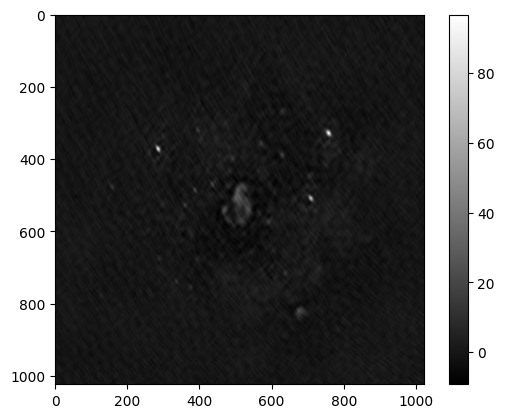

In [11]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Specify the path to the .fits file
fits_file_path = './image-CORRECTED_DATA.fits'

# Open the .fits file
image_data = fits.getdata(fits_file_path)

# Adjust the image_data to reduce its dimensionality to 2D
image_data_2d = image_data[0, 0, :, :]

# Now use plt.imshow on the 2D image data
plt.imshow(image_data_2d, cmap='gray')
plt.colorbar()
plt.show()








